In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import shutil
from PIL import Image
LEARNING_RATE = 0.0001

In [6]:

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


In [7]:
findings = ["Pneumonia", "Effusion", "Mass", "Atelectasis","Effusion"]
findings.append("Nodule")
findings.append("Cardiomegaly")
findings.append("Pneumothorax")
finding = "Pneumonia"


print(findings)

['Pneumonia', 'Effusion', 'Mass', 'Atelectasis', 'Effusion', 'Nodule', 'Cardiomegaly', 'Pneumothorax']


In [9]:
df = pd.read_csv('labels.csv')
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [10]:
pneumonia_positives = df.loc[df["label"] == "Pneumonia"]
pneumonia_negatives = df.loc[df["label"] == "No Finding"]
pneumonia_n = len(pneumonia_positives)


cardiomegaly_positives = df.loc[df["label"] == "Cardiomegaly"]
cardiomegaly_negatives = df.loc[df["label"] == "No Finding"]
cardiomegaly_n = len(cardiomegaly_positives)

atelectasis_positives = df.loc[df["label"] == "Atelectasis"]
atelectasis_negatives = df.loc[df["label"] == "No Finding"]
atelectasis_n = len(atelectasis_positives)


effusion_positives = df.loc[df["label"] == "Effusion"]
effusion_negatives = df.loc[df["label"] == "No Finding"]
effusion_n = len(atelectasis_positives)

print(pneumonia_n)
print(cardiomegaly_n)
print("Atelectasis: ", atelectasis_n)
print(effusion_n)
if pneumonia_n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (pneumonia_n > 0)

120
146
Atelectasis:  180
180


In [11]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
pneumonia_n = len(pneumonia_positives)
P_TRAIN_N = int(pneumonia_n*TRAIN_RATIO)
P_TEST_N = int(pneumonia_n*TEST_RATIO)


cardiomegaly_n = len(cardiomegaly_positives)
C_TRAIN_N = int(cardiomegaly_n*TRAIN_RATIO)
C_TEST_N = int(cardiomegaly_n*TEST_RATIO)

atelectasis_n = len(atelectasis_positives)
A_TRAIN_N = int(atelectasis_n*TRAIN_RATIO)
A_TEST_N = int(atelectasis_n*TEST_RATIO)
print(A_TRAIN_N, A_TEST_N)

effusion_n = len(effusion_positives)
E_TRAIN_N = int(effusion_n*TRAIN_RATIO)
E_TEST_N = int(effusion_n*TEST_RATIO)
print(E_TRAIN_N, E_TEST_N)

144 36
122 30


In [12]:
p_train_labels = pd.concat([pneumonia_positives[:P_TRAIN_N], pneumonia_negatives[:P_TRAIN_N]])
p_test_labels = pd.concat([pneumonia_positives[P_TRAIN_N:], pneumonia_negatives[P_TRAIN_N:pneumonia_n]])
print(len(p_train_labels))
print(len(p_test_labels))

c_train_labels = pd.concat([cardiomegaly_positives[:C_TRAIN_N], pneumonia_negatives[:C_TRAIN_N]])
c_test_labels = pd.concat([cardiomegaly_positives[C_TRAIN_N:], pneumonia_negatives[C_TRAIN_N:cardiomegaly_n]])
print(len(c_train_labels))
print(len(c_test_labels))

a_train_labels = pd.concat([atelectasis_positives[:A_TRAIN_N], atelectasis_negatives[:A_TRAIN_N]])
a_test_labels = pd.concat([atelectasis_positives[A_TRAIN_N:], atelectasis_negatives[A_TRAIN_N:atelectasis_n]])
print(len(a_train_labels))
print(len(a_test_labels))

e_train_labels = pd.concat([effusion_positives[:E_TRAIN_N], atelectasis_negatives[:E_TRAIN_N]])
e_test_labels = pd.concat([effusion_positives[E_TRAIN_N:], atelectasis_negatives[E_TRAIN_N:effusion_n]])
print(len(e_train_labels))
print(len(e_test_labels))

192
48
232
60
288
72
244
62


In [17]:
rootdir = "/Users/savraj/programming/X-R-A-I/data/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)


os.makedirs(rootdir+"Cardiomegaly"+ "/test/positive",  exist_ok=True)
os.makedirs(rootdir+"Cardiomegaly"+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+"Cardiomegaly"+"/train/positive", exist_ok=True)
os.makedirs(rootdir+"Cardiomegaly"+"/train/negative", exist_ok=True)


os.makedirs(rootdir+"Atelectasis" + "/test/positive",  exist_ok=True)
os.makedirs(rootdir+"Atelectasis" +"/test/negative",  exist_ok=True)
os.makedirs(rootdir+"Atelectasis" +"/train/positive", exist_ok=True)
os.makedirs(rootdir+"Atelectasis" +"/train/negative", exist_ok=True)

os.makedirs(rootdir+"Effusion" + "/test/positive",  exist_ok=True)
os.makedirs(rootdir+"Effusion" +"/test/negative",  exist_ok=True)
os.makedirs(rootdir+"Effusion" +"/train/positive", exist_ok=True)
os.makedirs(rootdir+"Effusion" +"/train/negative", exist_ok=True)

In [18]:

for idx, image in pneumonia_positives[:P_TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in pneumonia_positives[P_TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in pneumonia_negatives[:P_TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in pneumonia_negatives[P_TRAIN_N:pneumonia_n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(pneumonia_n*2)+"pneumonia images to positive and negative folders.")

Done moving 240pneumonia images to positive and negative folders.


In [19]:

for idx, image in cardiomegaly_positives[:C_TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+"/Cardiomegaly"+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in cardiomegaly_positives[C_TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+"/Cardiomegaly"+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in cardiomegaly_negatives[:C_TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+"/Cardiomegaly"+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in cardiomegaly_negatives[C_TRAIN_N:cardiomegaly_n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+"/Cardiomegaly"+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(cardiomegaly_n*2)+"c ardiomegaly images to positive and negative folders.")

Done moving 292c ardiomegaly images to positive and negative folders.


In [20]:

for idx, image in atelectasis_positives[:A_TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+"/Atelectasis"+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in atelectasis_positives[A_TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+"/Atelectasis"+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in atelectasis_negatives[:A_TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+"/Atelectasis"+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in atelectasis_negatives[A_TRAIN_N:atelectasis_n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+"/Atelectasis"+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(atelectasis_n*2)+" atelectasis images to positive and negative folders.")

Done moving 360 atelectasis images to positive and negative folders.


In [21]:
  for idx, image in effusion_positives[:E_TRAIN_N].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+"/Effusion"+"/train/positive/"+image["filename"]
    shutil.copy(source, dst)

  for idx, image in effusion_positives[E_TRAIN_N:].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+"/Effusion"+"/test/positive/"+image["filename"]
    shutil.copy(source, dst)

  for idx, image in effusion_negatives[:E_TRAIN_N].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+"/Effusion"+"/train/negative/"+image["filename"]
    shutil.copy(source, dst)

  for idx, image in effusion_negatives[E_TRAIN_N:effusion_n].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+"/Effusion"+"/test/negative/"+image["filename"]
    shutil.copy(source, dst)

  print("Done moving "+str(effusion_n*2)+" effusion images to positive and negative folders.")

Done moving 306 effusion images to positive and negative folders.


In [22]:

positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in pneumonia_positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in pneumonia_negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

In [23]:

c_positive_imgs, c_negative_imgs = [], []


for idx, row in cardiomegaly_positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  c_positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in cardiomegaly_negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  c_negative_imgs.append(load_image_into_numpy_array(image))

In [24]:

a_positive_imgs, a_negative_imgs = [], []

for idx, row in atelectasis_positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  a_positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in atelectasis_negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  a_negative_imgs.append(load_image_into_numpy_array(image))

In [25]:
e_positive_imgs, e_negative_imgs = [], []

for idx, row in effusion_positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  e_positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in effusion_negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  e_negative_imgs.append(load_image_into_numpy_array(image))

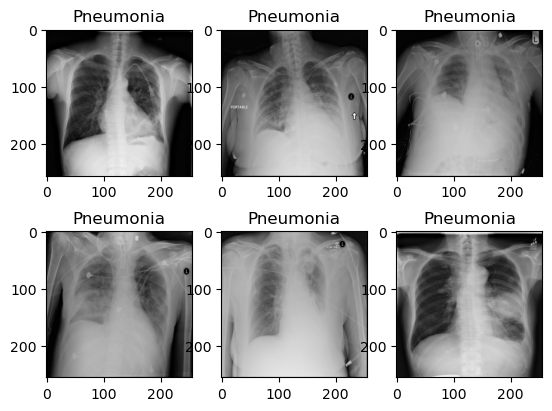

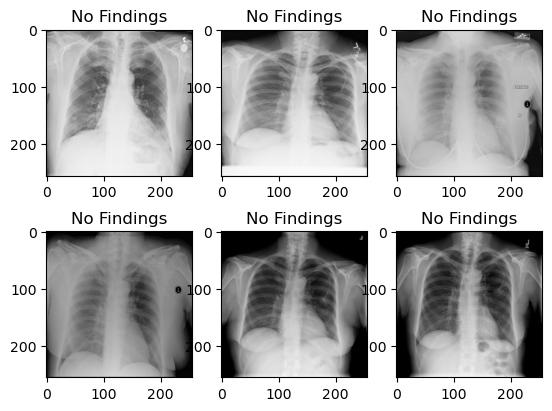

In [26]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

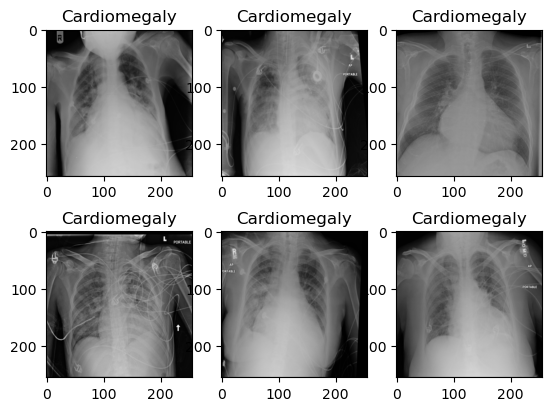

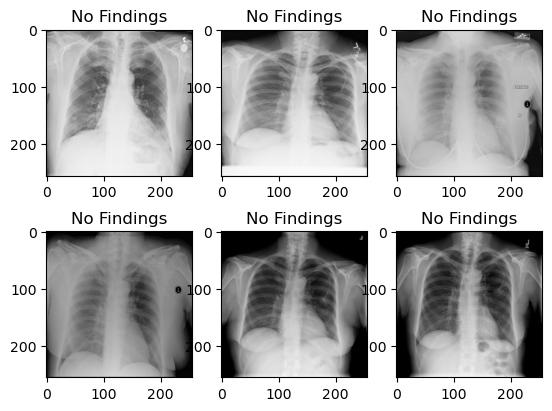

In [27]:
for idx, img in enumerate(c_positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("Cardiomegaly")
  plt.imshow(c_positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(c_negative_imgs[idx])
plt.show()

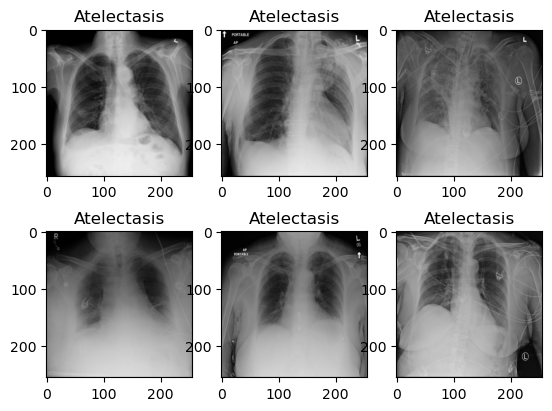

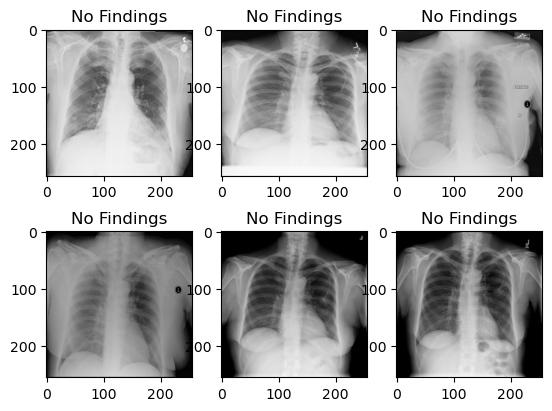

In [28]:
for idx, img in enumerate(a_positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("Atelectasis")
  plt.imshow(a_positive_imgs[idx])
plt.show()

for idx, img in enumerate(a_negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(a_negative_imgs[idx])
plt.show()

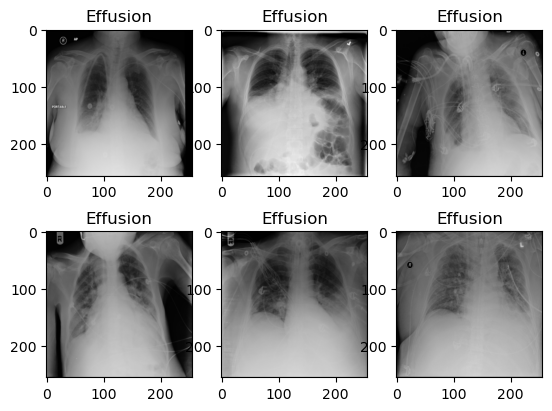

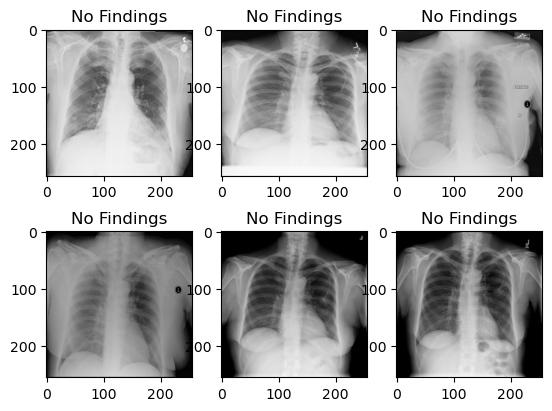

In [29]:
for idx, img in enumerate(e_positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("Effusion")
  plt.imshow(e_positive_imgs[idx])
plt.show()

for idx, img in enumerate(e_negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(e_negative_imgs[idx])
plt.show()

In [30]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Model

IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(last_output)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

Done compiling the model!


In [37]:
# Define our example directories and files
base_dir = rootdir = "/Users/savraj/programming/X-R-A-I/data/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [39]:
c_train_dir = os.path.join(base_dir, "Cardiomegaly", 'train')
c_test_dir = os.path.join(base_dir, "Cardiomegaly", 'test')

c_train_pos_dir = os.path.join(c_train_dir, 'positive')
c_train_neg_dir = os.path.join(c_train_dir, 'negative')
c_test_pos_dir = os.path.join(c_test_dir, 'positive')
c_test_neg_dir = os.path.join(c_test_dir, 'negative')

In [40]:
a_train_dir = os.path.join(base_dir, "Atelectasis", 'train')
a_test_dir = os.path.join(base_dir, "Atelectasis", 'test')

a_train_pos_dir = os.path.join(a_train_dir, 'positive')
a_train_neg_dir = os.path.join(a_train_dir, 'negative')
a_test_pos_dir = os.path.join(a_test_dir, 'positive')
a_test_neg_dir = os.path.join(a_test_dir, 'negative')

In [41]:
e_train_dir = os.path.join(base_dir, "Effusion", 'train')
e_test_dir = os.path.join(base_dir, "Effusion", 'test')

e_train_pos_dir = os.path.join(e_train_dir, 'positive')
e_train_neg_dir = os.path.join(e_train_dir, 'negative')
e_test_pos_dir = os.path.join(e_test_dir, 'positive')
e_test_neg_dir = os.path.join(e_test_dir, 'negative')

In [42]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)


val_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 192 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Done funneling data!


In [44]:
a_train_generator = train_datagen.flow_from_directory(
        a_train_dir, 
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

a_test_generator = val_datagen.flow_from_directory(
        a_test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

a_train_steps = len(os.listdir(a_train_pos_dir)) * 2
a_test_steps = len(os.listdir(a_test_pos_dir)) * 2
print("Done funneling data!")

Found 288 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Done funneling data!


In [45]:
c_train_generator = train_datagen.flow_from_directory(
        c_train_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

c_test_generator = val_datagen.flow_from_directory(
        c_test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

c_train_steps = len(os.listdir(c_train_pos_dir)) * 2
c_test_steps = len(os.listdir(c_test_pos_dir)) * 2
print("Done funneling data!")

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Done funneling data!


In [46]:
e_train_generator = train_datagen.flow_from_directory(
        e_train_dir, 
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

e_test_generator = val_datagen.flow_from_directory(
        e_test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

e_train_steps = len(os.listdir(e_train_pos_dir)) * 2
e_test_steps = len(os.listdir(e_test_pos_dir)) * 2
print("Done funneling data!")

Found 244 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Done funneling data!


In [47]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=24,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

Epoch 1/24


2024-04-08 00:00:15.501297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-08 00:00:30.762872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


192/192 - 19s - loss: 0.7666 - acc: 0.4896 - val_loss: 0.7013 - val_acc: 0.5000 - 19s/epoch - 97ms/step
Epoch 2/24
192/192 - 16s - loss: 0.7066 - acc: 0.4792 - val_loss: 0.6914 - val_acc: 0.5000 - 16s/epoch - 83ms/step
Epoch 3/24
192/192 - 17s - loss: 0.7516 - acc: 0.5260 - val_loss: 0.6559 - val_acc: 0.6250 - 17s/epoch - 89ms/step
Epoch 4/24
192/192 - 17s - loss: 0.7634 - acc: 0.6042 - val_loss: 0.6707 - val_acc: 0.7083 - 17s/epoch - 89ms/step
Epoch 5/24
192/192 - 18s - loss: 0.6568 - acc: 0.6510 - val_loss: 0.6452 - val_acc: 0.5625 - 18s/epoch - 92ms/step
Epoch 6/24
192/192 - 18s - loss: 0.6147 - acc: 0.6875 - val_loss: 0.6007 - val_acc: 0.6875 - 18s/epoch - 95ms/step
Epoch 7/24
192/192 - 18s - loss: 0.5859 - acc: 0.7188 - val_loss: 0.5325 - val_acc: 0.7083 - 18s/epoch - 94ms/step
Epoch 8/24
192/192 - 18s - loss: 0.5525 - acc: 0.7188 - val_loss: 0.5705 - val_acc: 0.7083 - 18s/epoch - 95ms/step
Epoch 9/24
192/192 - 20s - loss: 0.5279 - acc: 0.7552 - val_loss: 0.6245 - val_acc: 0.7083 

In [48]:
model.save('pneumonia_model.keras')

In [49]:
c_history = model.fit(
      c_train_generator,
      steps_per_epoch=train_steps,
      epochs=24,
      validation_data=c_test_generator,
      validation_steps=c_test_steps,
      verbose=2)

Epoch 1/24


2024-04-08 00:09:02.224343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-08 00:09:15.687879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


192/192 - 17s - loss: 0.5374 - acc: 0.7812 - val_loss: 0.5031 - val_acc: 0.7833 - 17s/epoch - 90ms/step
Epoch 2/24
192/192 - 19s - loss: 0.4759 - acc: 0.7969 - val_loss: 0.6773 - val_acc: 0.6667 - 19s/epoch - 99ms/step
Epoch 3/24
192/192 - 20s - loss: 0.4162 - acc: 0.8281 - val_loss: 0.4382 - val_acc: 0.8333 - 20s/epoch - 105ms/step
Epoch 4/24
192/192 - 19s - loss: 0.4506 - acc: 0.8125 - val_loss: 0.5296 - val_acc: 0.7833 - 19s/epoch - 101ms/step
Epoch 5/24
192/192 - 20s - loss: 0.3848 - acc: 0.8281 - val_loss: 0.4586 - val_acc: 0.8167 - 20s/epoch - 103ms/step
Epoch 6/24
192/192 - 20s - loss: 0.3420 - acc: 0.8438 - val_loss: 0.5607 - val_acc: 0.8000 - 20s/epoch - 105ms/step
Epoch 7/24
192/192 - 20s - loss: 0.3189 - acc: 0.8594 - val_loss: 0.6157 - val_acc: 0.7833 - 20s/epoch - 104ms/step
Epoch 8/24
192/192 - 20s - loss: 0.3103 - acc: 0.8750 - val_loss: 0.9769 - val_acc: 0.6333 - 20s/epoch - 104ms/step
Epoch 9/24
192/192 - 20s - loss: 0.3042 - acc: 0.8542 - val_loss: 0.3575 - val_acc: 0

In [50]:

model.save('cardiomegaly_model.keras')

In [51]:
a_history = model.fit(
      a_train_generator,
      steps_per_epoch=a_train_steps,
      epochs=12,
      validation_data=a_test_generator,
      validation_steps=a_test_steps,
      verbose=2)

Epoch 1/12


2024-04-08 00:17:12.331098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-08 00:17:35.460308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


288/288 - 28s - loss: 0.5163 - acc: 0.7639 - val_loss: 0.5391 - val_acc: 0.6389 - 28s/epoch - 99ms/step
Epoch 2/12
288/288 - 30s - loss: 0.4305 - acc: 0.8160 - val_loss: 0.5325 - val_acc: 0.6667 - 30s/epoch - 103ms/step
Epoch 3/12
288/288 - 29s - loss: 0.3811 - acc: 0.8438 - val_loss: 0.7103 - val_acc: 0.6944 - 29s/epoch - 102ms/step
Epoch 4/12
288/288 - 30s - loss: 0.4780 - acc: 0.7882 - val_loss: 0.6787 - val_acc: 0.6667 - 30s/epoch - 103ms/step
Epoch 5/12
288/288 - 33s - loss: 0.4150 - acc: 0.8368 - val_loss: 0.6477 - val_acc: 0.6667 - 33s/epoch - 115ms/step
Epoch 6/12
288/288 - 37s - loss: 0.3783 - acc: 0.8333 - val_loss: 0.6589 - val_acc: 0.6528 - 37s/epoch - 128ms/step
Epoch 7/12
288/288 - 35s - loss: 0.4114 - acc: 0.8299 - val_loss: 0.6285 - val_acc: 0.7361 - 35s/epoch - 123ms/step
Epoch 8/12
288/288 - 30s - loss: 0.4134 - acc: 0.8264 - val_loss: 0.7409 - val_acc: 0.7222 - 30s/epoch - 104ms/step
Epoch 9/12
288/288 - 29s - loss: 0.4177 - acc: 0.8160 - val_loss: 0.6860 - val_acc: 

In [52]:
model.save('atelectasis_model.keras')

In [53]:
e_history = model.fit(
      e_train_generator,
      steps_per_epoch=train_steps,
      epochs=12,
      validation_data=e_test_generator,
      validation_steps=e_test_steps,
      verbose=2)

Epoch 1/12


2024-04-08 00:24:04.506490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-08 00:24:25.492173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


192/192 - 27s - loss: 0.2696 - acc: 0.8906 - val_loss: 0.4064 - val_acc: 0.8387 - 27s/epoch - 140ms/step
Epoch 2/12
192/192 - 26s - loss: 0.2875 - acc: 0.9062 - val_loss: 0.6624 - val_acc: 0.8387 - 26s/epoch - 137ms/step
Epoch 3/12
192/192 - 26s - loss: 0.2412 - acc: 0.8906 - val_loss: 0.8677 - val_acc: 0.7742 - 26s/epoch - 137ms/step
Epoch 4/12
192/192 - 26s - loss: 0.2649 - acc: 0.8906 - val_loss: 0.6292 - val_acc: 0.8387 - 26s/epoch - 134ms/step
Epoch 5/12
192/192 - 21s - loss: 0.2412 - acc: 0.9167 - val_loss: 0.8122 - val_acc: 0.7903 - 21s/epoch - 110ms/step
Epoch 6/12
192/192 - 22s - loss: 0.2484 - acc: 0.8854 - val_loss: 0.5539 - val_acc: 0.8065 - 22s/epoch - 114ms/step
Epoch 7/12
192/192 - 21s - loss: 0.2773 - acc: 0.9010 - val_loss: 0.4467 - val_acc: 0.8226 - 21s/epoch - 111ms/step
Epoch 8/12
192/192 - 21s - loss: 0.1825 - acc: 0.9583 - val_loss: 0.8272 - val_acc: 0.8065 - 21s/epoch - 109ms/step
Epoch 9/12
192/192 - 21s - loss: 0.2034 - acc: 0.9271 - val_loss: 0.4531 - val_acc:

In [54]:
model.save('effusion_model.keras')